<h1 align='center'><u>SMS Spam Detection using NLP </u></h1>

In [120]:
!pip install feature-engine -qq

In [121]:
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
!pip install -U spacy -qq

In [123]:
# Import Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import textwrap as tw
import matplotlib.pyplot as plt

# learning Curves
from sklearn.model_selection import learning_curve

# save and load models
import joblib

import re
from bs4 import BeautifulSoup
import spacy

#from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from  sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support

In [124]:
!pip install preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
spacy.__version__

'3.4.2'

In [127]:
data_folder = Path('/content/drive/MyDrive/Colab Notebooks')


In [128]:
model_folder = Path('/content/drive/MyDrive/Colab Notebooks/Models')


In [ ]:
!python -m spacy download 'en_core_web_sm'

## Loading the dataset

In [130]:
# load spacy model
nlp = spacy.load('en_core_web_sm')

In [131]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Custom_functions')

In [132]:
# location of spam files
spam_file = data_folder / 'spam.csv'

In [209]:
# creating Pandas Dataframe
spam_data = pd.read_csv(spam_file, encoding='latin-1')
spam_data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [210]:
spam_data = spam_data.iloc[:,0:2]

In [219]:
spam_data= spam_data.rename(columns={"v1":"label","v2":"message"})

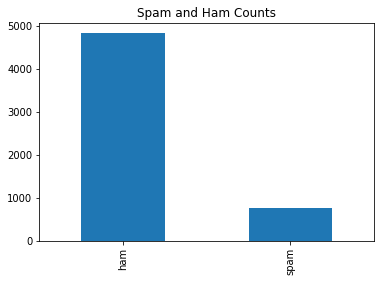

In [220]:
import pylab as plt

# Plot fraus and nonfraud counts
spam_data['label'].value_counts().plot(kind='bar', title='Spam and Ham Counts')

## Percentage of ham amd spam in the data #

In [223]:
#the % ham amd spam in the data
spam_data['label'].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: label, dtype: float64

## Encoding for labels: 'ham' = 0 and 'spam' = 1

In [137]:
spam_data['label'] = spam_data['label'].map({'ham':0,'spam':1}).astype(int)
spam_data

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


## Deciding the metric for evaluating model.

**F0.5 Score**

**In this case we consider 'spam' as positive label and 'ham' as negative label since the goal is to predict spam emails correctly. If spam emails remain undetected (Type II error /FN) it is still okay. But if we miss any critical email because it is classified as 'spam' (Type I error/FP) it will be problematic. Usually, spam folders are neglected so this might impact the user. Hence, here precision is more important i.e. out of all the spam emails predicted what percentage is truly spam emails. However, out dataset is highly imbalanced with higher count for the negative class (i.e. ham). The likeliness of predicting the negative label for new observation is more than the positive label. This means, we also need to reduce False Negatives (Type II error) to predict the class correctly. The F measure gives the same weightage to both precision and recall.Thus, we use Fbeta measure with beta = 0.5. This is a useful metric to use when both precision and recall are important but slightly more attention is needed on one or the other, in our case false positives are more important than false negatives. The smaller beta value gives more weightage to precision and less to recall. Hence, we use 'F0.5 score' as a metric for evaluation of the model.**


## Classification Pipelines

### Subset Data 

In [138]:
subset_data = spam_data.sample(round(0.4 * len(spam_data)), random_state = 0)

### Train-Test Split

In [139]:
X_train, X_test, y_train, y_test = train_test_split(subset_data['message'].values, subset_data['label'].values, test_size=0.30, random_state=0)

In [140]:
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (1560,) y_train: (1560,)
X_test: (669,) y_test: (669,)


## Pipeline1. Data Processing + Sparse Embeddings (TF-IDF) + ML Model

In [141]:
#importing custom_preprocessor, featurizer4 and learning_curve_fhalf
import custom_preprocessor as cp

from  featurizer4 import ManualFeatures

from  learning_curve_fhalf import plot_learning_curve

#### Pre-processing

In [142]:
X_train_cleaned = cp.SpacyPreprocessor(model ='en_core_web_sm', remove_stop=True,remove_url=False).transform(X_train)

In [143]:
# save  this to a file
X_train_cleaned_sparse_embed = model_folder / 'x_train_cleaned_sparse_embed.pkl'

In [144]:
joblib.dump(X_train_cleaned, X_train_cleaned_sparse_embed)

['/content/drive/MyDrive/Colab Notebooks/Models/x_train_cleaned_sparse_embed.pkl']

#### Create Pipeline

In [145]:
classifier_1a = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+",ngram_range=(1,3))),
                         ('classifier', XGBClassifier(weights = 10))])

#### Parameter Grid

In [146]:
param_grid_classifier_1a = {'vectorizer__max_features': [500, 1000, 2000, 5000],
                           'vectorizer__max_df': [10,20,50],
                           'classifier__learning_rate': np.linspace(0.01,1,10)}                         

#### Apply RandomizedSearch

In [147]:
grid_classifier_1a = RandomizedSearchCV(classifier_1a, param_grid_classifier_1a, scoring=make_scorer(fbeta_score, beta=0.5), random_state=0, cv = 3, return_train_score=True, error_score='raise')

In [148]:
# Fit the model on training data
grid_classifier_1a.fit(X_train_cleaned, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           3),
                                                              token_pattern='[\\S]+')),
                                             ('classifier',
                                              XGBClassifier(weights=10))]),
                   param_distributions={'classifier__learning_rate': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                                        'vectorizer__max_df': [10, 20, 50],
                                        'vectorizer__max_features': [500, 1000,
                                                                     2000,
                                                                     5000]},
                   random_state=0, return_train_score=True,
       

In [149]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1a.best_score_))
print("\nBest parameters: ", grid_classifier_1a.best_params_)
print("\nBest estimator: ", grid_classifier_1a.best_estimator_)

Best cross-validation score: 0.85

Best parameters:  {'vectorizer__max_features': 1000, 'vectorizer__max_df': 50, 'classifier__learning_rate': 0.34}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=50, max_features=1000,
                                 ngram_range=(1, 3), token_pattern='[\\S]+')),
                ('classifier', XGBClassifier(learning_rate=0.34, weights=10))])


In [150]:
file_model_sparse_embed = model_folder / 'sparse_embed_model.pkl'

In [151]:
joblib.dump(grid_classifier_1a.best_estimator_, file_model_sparse_embed)

['/content/drive/MyDrive/Colab Notebooks/Models/sparse_embed_model.pkl']

In [152]:
# load the saved model
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

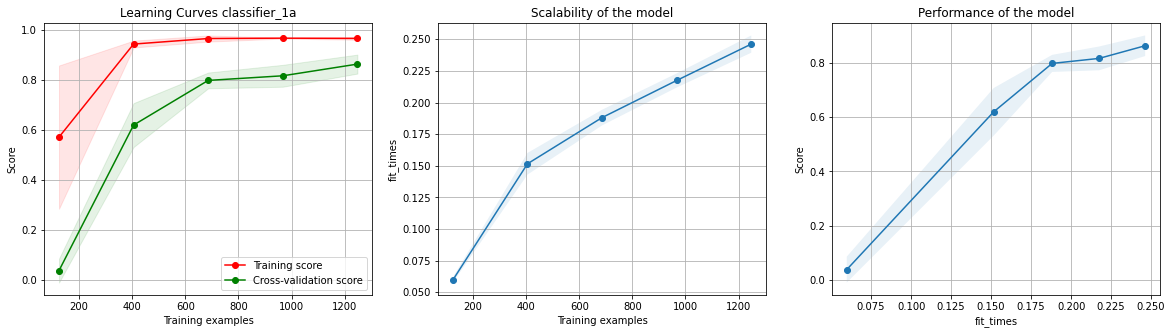

In [153]:
# plot learning curves for f0.5 score
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves classifier_1a', X_train_cleaned, y_train)

### Evaluate model on test datset

In [154]:
# Final Pipeline
def final_pipeline(text):
  cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  predictions = loaded_model_sparse_embed.predict(cleaned_text)
  return predictions

In [155]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [156]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.94      0.99      0.97       577
           1       0.95      0.63      0.76        92

    accuracy                           0.94       669
   macro avg       0.95      0.81      0.86       669
weighted avg       0.95      0.94      0.94       669



In [157]:
print('\n F0.5 Score: ', fbeta_score(y_test, y_test_pred, beta=0.5))


 F0.5 Score:  0.863095238095238


## Pipeline2. Data Processing + Manual Features + ML Model

In this case we will extract following features and use these as the input to our XGBoost Classification model.
  1. number of words
  2. number of characters
  3. number of digits
  6. number of numbers
  7. number of nouns or propernouns
  8. number of aux
  9. number of verbs
  10. number of adjectives
  11. number of ner (entiites)
  12. number of punctuation marks 
  13. number of exclamation marks
  13. number of urls or websites
  14. number of "free" words
  15. number of "T&C/t&c/tandc" words
  16. number of words followed by one or more exclamation marks


In [158]:
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

In [159]:
X_train_features, feature_names  = featurizer.fit_transform(X_train)

In [160]:
X_train_features[0:3]

array([[ 49, 230,   0,   0,   2,  16,   2,   6,   3,   6,   0,   0,   0,
          0,   0],
       [ 20,  81,   0,   0,   0,   5,   1,   3,   0,   4,   0,   1,   0,
          0,   0],
       [ 12,  55,   0,   0,   0,   4,   0,   2,   0,   2,   0,   0,   0,
          0,   0]])

In [161]:
feature_names 

['count_words',
 'count_characters',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner',
 'punct_count',
 'url_count',
 'exclam_count',
 'free_count',
 'tc_count',
 'wordexcl_count']

#### Create Pipeline

In [162]:
classifier_1b = Pipeline([('classifier', XGBClassifier()),])

#### Parameter Grid

In [163]:
param_grid_classifier_1b = {'classifier__weights': [1, 10, 25, 50, 75, 99, 100, 1000],
                            'classifier__learning_rate': [0.1, 0.5, 1],}

#### Apply GridSearch

In [164]:
grid_classifier_1b = RandomizedSearchCV(classifier_1b, param_grid_classifier_1b,scoring=make_scorer(fbeta_score, beta=0.5), random_state=0, cv = 3,return_train_score=True, error_score='raise')

In [165]:
# Fit the model on training data
grid_classifier_1b.fit(X_train_features, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('classifier', XGBClassifier())]),
                   param_distributions={'classifier__learning_rate': [0.1, 0.5,
                                                                      1],
                                        'classifier__weights': [1, 10, 25, 50,
                                                                75, 99, 100,
                                                                1000]},
                   random_state=0, return_train_score=True,
                   scoring=make_scorer(fbeta_score, beta=0.5))

In [166]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1b.best_score_))
print("\nBest parameters: ", grid_classifier_1b.best_params_)
print("\nBest estimator: ", grid_classifier_1b.best_estimator_)

Best cross-validation score: 0.91

Best parameters:  {'classifier__weights': 10, 'classifier__learning_rate': 0.1}

Best estimator:  Pipeline(steps=[('classifier', XGBClassifier(weights=10))])


In [167]:
file_model_features = model_folder / 'features_model.pkl'

In [168]:
joblib.dump(grid_classifier_1b.best_estimator_, file_model_features)

['/content/drive/MyDrive/Colab Notebooks/Models/features_model.pkl']

In [169]:
# load the saved model
loaded_final_model_features = joblib.load(file_model_features)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

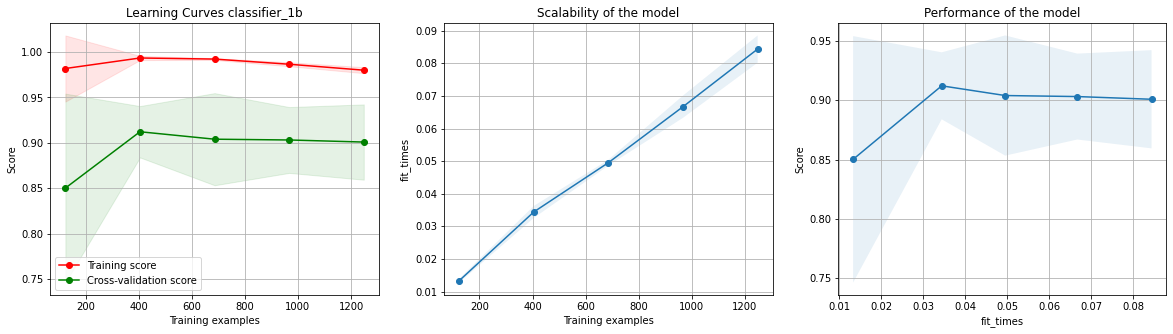

In [170]:
# plot learning curves for f0.5 score
plot_learning_curve(loaded_final_model_features, 'Learning Curves classifier_1b', X_train_features, y_train)

#### Evaluate model on test datset

In [171]:
# Final Pipeline
def final_pipeline(text):
  test_features, feature_names = featurizer.fit_transform(X_test)
  predictions = loaded_final_model_features.predict(test_features)
  return predictions

In [172]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [173]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       577
           1       0.94      0.88      0.91        92

    accuracy                           0.98       669
   macro avg       0.96      0.94      0.95       669
weighted avg       0.98      0.98      0.98       669



In [174]:
print('\nF0.5 Score: ', fbeta_score(y_test, y_test_pred, beta=0.5))


F0.5 Score:  0.9288990825688073


## Pipeline3: Data Processing + Combine Manual Features and TfID vectors + ML Model (6 Points) ##

In [175]:
X_train_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_train)

In [176]:
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

In [177]:
X_train_features, feature_names  = featurizer.fit_transform(X_train)

In [178]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned, columns = ['cleaned_text']),
                           pd.DataFrame(X_train_features, columns = feature_names)),axis =1)

In [179]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,punct_count,url_count,exclam_count,free_count,tc_count,wordexcl_count
0,thank reply today ur visa come r u buy gucci b...,49,230,0,0,2,16,2,6,3,6,0,0,0,0,0
1,find diff farm shop buy cheese way,20,81,0,0,0,5,1,3,0,4,0,1,0,0,0
2,hey gal u go e drive centre tmr,12,55,0,0,0,4,0,2,0,2,0,0,0,0,0
3,oh unintentionally bad timing great finger t...,16,101,0,0,1,5,1,2,2,4,0,1,0,0,0
4,time tell friend,10,46,0,0,0,2,2,1,0,1,0,0,0,0,0


In [180]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cleaned_text      1560 non-null   object
 1   count_words       1560 non-null   int64 
 2   count_characters  1560 non-null   int64 
 3   count_digits      1560 non-null   int64 
 4   count_numbers     1560 non-null   int64 
 5   noun_count        1560 non-null   int64 
 6   aux_count         1560 non-null   int64 
 7   verb_count        1560 non-null   int64 
 8   adj_count         1560 non-null   int64 
 9   ner               1560 non-null   int64 
 10  punct_count       1560 non-null   int64 
 11  url_count         1560 non-null   int64 
 12  exclam_count      1560 non-null   int64 
 13  free_count        1560 non-null   int64 
 14  tc_count          1560 non-null   int64 
 15  wordexcl_count    1560 non-null   int64 
dtypes: int64(15), object(1)
memory usage: 195.1+ KB


In [181]:
subset = X_train_final[0:10]

In [182]:
subset.shape

(10, 16)

In [183]:
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix
class SparseTransformer(TransformerMixin, BaseEstimator):
    
  def __init__(self):
    return None

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      return csr_matrix(X)
 

In [184]:
sparse_features = Pipeline([('sparse', SparseTransformer()),                     
                        ]) 
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)),                     
                        ]) 

In [185]:
sparse_features.fit_transform(subset.iloc[:,1:])

<10x15 sparse matrix of type '<class 'numpy.int64'>'
	with 78 stored elements in Compressed Sparse Row format>

In [186]:
vectorizer.fit_transform(subset.iloc[:,0])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [187]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [188]:
test = combined_features.fit_transform(subset)

In [189]:
test.dtype

dtype('float64')

#### Create Pipeline

In [190]:
classifier_1c = Pipeline([('combined_features',  combined_features),
                         ('classifier', XGBClassifier()), ])

In [191]:
classifier_1c.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

#### Parameter Grid

In [192]:
param_grid_classifier_1c = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                            'classifier__weights': [1, 10, 25, 50, 75, 99, 100, 1000],
                            'classifier__learning_rate': np.linspace(0.01,1,10)}

#### Apply GridSearch

In [193]:
grid_classifier_1c = RandomizedSearchCV(classifier_1c, param_grid_classifier_1c,scoring=make_scorer(fbeta_score, beta=0.5), random_state=0, cv = 3,return_train_score=True, error_score='raise')

In [194]:
# Fit the model on training data
grid_classifier_1c.fit(X_train_final, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('combined_features',
                                              ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                           SparseTransformer())]),
                                                                transformers=[('tfidf',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer(max_features=5))]),
                                                                               'cleaned_text')])),
                                             ('classifier', XGBClassifier())]),
                   param_distributions={'classifier__learning_rate': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                             

In [195]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1c.best_score_))
print("\nBest parameters: ", grid_classifier_1c.best_params_)
print("\nBest estimator: ", grid_classifier_1c.best_estimator_)

Best cross-validation score: 0.93

Best parameters:  {'combined_features__tfidf__tfidf__max_features': 2000, 'classifier__weights': 1, 'classifier__learning_rate': 0.34}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=2000))]),
                                                  'cleaned_text')])),
                ('classifier', XGBClassifier(learning_rate=0.34, weights=1))])


In [196]:
file_model_combined = model_folder / 'combined_model.pkl'

In [197]:
joblib.dump(grid_classifier_1c.best_estimator_, file_model_combined)

['/content/drive/MyDrive/Colab Notebooks/Models/combined_model.pkl']

In [198]:
# load the saved model
loaded_model_combined = joblib.load(file_model_combined)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

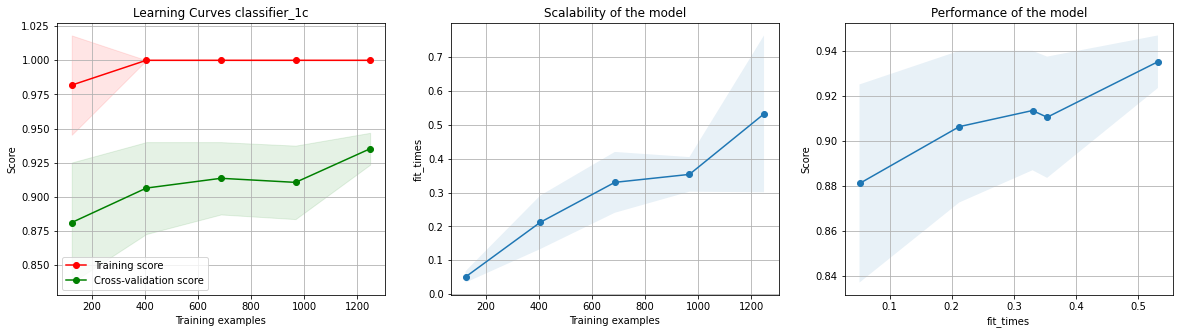

In [199]:
# plot learning curves for f0.5 score
plot_learning_curve(loaded_model_combined, 'Learning Curves classifier_1c', X_train_final, y_train)

#### Evaluate model on test datset

In [200]:
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_test)

In [201]:
# save  this to a file
X_test_cleaned_sparse_embed = model_folder / 'x_test_cleaned_sparse_embed.pkl'

In [202]:
joblib.dump(X_test_cleaned, X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/Colab Notebooks/Models/x_test_cleaned_sparse_embed.pkl']

In [203]:
# Final Pipeline
def final_pipeline(text):
  cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  X_features, feature_names  = featurizer.fit_transform(text)
  X_final = pd.concat((pd.DataFrame(cleaned_text, columns =['cleaned_text']), 
                           pd.DataFrame(X_features, columns=feature_names)),axis =1)
  
  predictions = loaded_model_combined.predict(X_final)
  return predictions

In [204]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [205]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       577
           1       0.96      0.85      0.90        92

    accuracy                           0.97       669
   macro avg       0.97      0.92      0.94       669
weighted avg       0.97      0.97      0.97       669



In [206]:
print('\nF0.5 Score: ', fbeta_score(y_test, y_test_pred, beta=0.5))


F0.5 Score:  0.9375000000000001
